In [7]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

### Successive Convexification (Implementation)

Packages required: numpy, cvxpy, matplotlib.

[1] Szmuk, M., Acikmese, B., & Berning, A. W. (2016). Successive Convexification for Fuel-Optimal Powered Landing with Aerodynamic Drag and Non-Convex Constraints. AIAA Guidance, Navigation, and Control Conference. doi:10.2514/6.2016-0378 

In [8]:
def init_plot(figsize):
    fig, ax = plt.subplots(figsize=figsize)
    return ax
  
def plot_environment(ax, r_obs, R_obs, x_init, x_des):
    ax.plot(*x_des[:2],'^',label='destination')
    ax.plot(*x_init[:2],'*',label='initial')
    _t = np.linspace(0,2*np.pi,25)
    for r,R in zip(r_obs, R_obs):
        ax.add_artist(plt.Circle(r, R, color='k', alpha=1))
    ax.set(xlim=[-1.1,1.1], ylim=[-1.1,1.1])
    return ax

def plot_trajectory(ax, x, **kwargs):
    ax.plot(x[:,0], x[:,1], 'o-', ms=5, **kwargs)

**Example 1. Point mass in 2D with boundary conditions**

In [9]:
def cvx(problem_size, solver='SCS'):
    N, (nx, nu), (ns, nq) = problem_size
    
    x = cp.Variable((N,nx))
    u = cp.Variable((N-1,nu))
    
    A = cp.Parameter((nx,nx))
    B = cp.Parameter((nx,nu))
    x_init = cp.Parameter(nx)
    x_des = cp.Parameter(nx)
    
    cost = cp.norm(u)**2
    dynamics = [x[i+1] == A@x[i] + B@u[i] for i in range(N-1)]
    dynamics += [x[0] == x_init, 
                 x[-1] == x_des]
    
    def init():
        opt = cp.Problem(cp.Minimize(cost), dynamics)
        return opt
      
    def update(opt, parameters):
        vehicle, waypoints = parameters
        A.value = vehicle[0]
        B.value = vehicle[1]
        x_init.value, x_des.value = waypoints
        
        cost = opt.solve(solver=solver)
        return opt, cost
      
    def get(opt):
        return x.value, u.value
      
    return init, update, get

**Example 2. Point mass in 2D with circle obstacles**

Iteration 0000


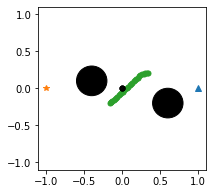

('optimal_inaccurate', 1587476.865574711, 0.0, 0.0, Variable(()))
Iteration 0001


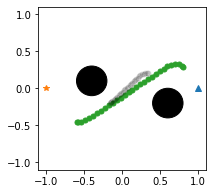

('optimal_inaccurate', 1023000.1450809806, 4.610683750828409, 0.01680721001298685, Variable(()))
Iteration 0002


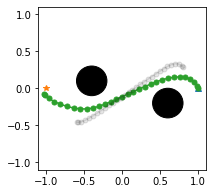

('optimal_inaccurate', 136091.30927459567, 54.801570587438164, 0.02668042944197812, Variable(()))
Iteration 0003


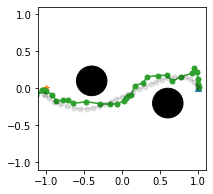

('optimal_inaccurate', 2580826.9883405566, 108.24562672636569, 0.03594059311338253, Variable(()))
Iteration 0004


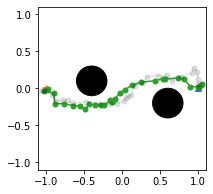

('optimal_inaccurate', 2114661.7343437704, 74.35513153047083, 5.389941561897984, Variable(()))
Iteration 0005


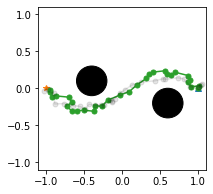

('optimal_inaccurate', 2320465.6250391924, 58.200901730868296, 4.94902222152914, Variable(()))
Iteration 0006


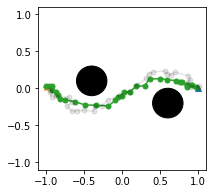

('optimal_inaccurate', 1678758.961698716, 51.0217765876241, 5.012824713004657, Variable(()))
Iteration 0007


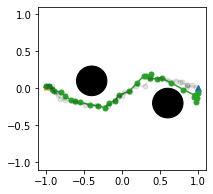

('optimal_inaccurate', 2123469.5001824927, 46.574979390146886, 3.7480513553801695, Variable(()))
Iteration 0008


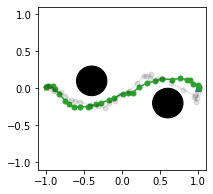

('optimal_inaccurate', 1333722.998851162, 47.83250116633834, 4.406568569149497, Variable(()))
Iteration 0009


KeyboardInterrupt: 

In [12]:
def scvx(problem_size, weights=dict(penalty=1e7, trust=1e4), solver='SCS'):
    """ Successive Convexification: SCvx """
    N, (nx, nu), (ns, nq) = problem_size
    
    ''' Costs '''
    R_np = np.eye(nu)
    cost = lambda x,u: sum([cp.quad_form(u[i],R_np)  for i in range(N-1)])
    cost_np = lambda x,u: sum([u[i].T @ R_np @ u[i]  for i in range(N-1)])

    ''' Non-convex dynamics and constraints '''
    f = lambda A, B: lambda x,u: A@x + B@u
    
    ''' Derivative helpers '''
    T = np.block([np.eye(2), np.zeros((2,2))])
    s_helper = lambda i,j,x,u,r_obs,R_obs: -(np.linalg.norm(T@x[i] - r_obs[i][j])**2 -(R_obs[i][j])**2)
    ds_helper = lambda i,j,x,u,r_obs,R_obs: -2*T.T @ (T @ x[i] - r_obs[i][j])
    s = lambda x,u,r_obs,R_obs: np.block([[s_helper(i, j, x, u, r_obs, R_obs) for j in range(ns)] # or x[i+1]?
                                                    for i in range(N-1)])
    ds = lambda i,x,u,r_obs,R_obs: np.block([[ds_helper(i, j, x, u, r_obs, R_obs)] for j in range(ns)])
    
    ''' Variables and parameters for cvx '''
    E, nv = np.eye(nx), nx
    λ = np.ones((N-1))*weights['trust']

    d = cp.Variable((N,nx))
    w = cp.Variable((N-1,nu))
    v = cp.Variable((N-1,nv))
    s_prime = cp.Variable((N-1,ns))

    x0 = cp.Parameter((nx))
    xN = cp.Parameter((nx))
    x = cp.Parameter((N,nx))
    u = cp.Parameter((N-1,nu))
    trust_region = cp.Variable()
    
    # Linearization
    A = [cp.Parameter((nx, nx)) for _ in range(N-1)]
    B = [cp.Parameter((nx, nu)) for _ in range(N-1)]
    S = [cp.Parameter((ns, nx)) for _ in range(N-1)]
    Q = [cp.Parameter((nq, nu)) for _ in range(N-1)]
    s_eval = cp.Parameter((N-1,ns))
    f_eval = cp.Parameter((N-1, nx))
    
    variables = (d,w,v,s_prime)
    parameters = (x,u,trust_region)
    linearization = (A,B,S,Q,s_eval,f_eval)

    ''' Penalty helper functions '''
    penalty_constraint = lambda x: cp.sum(cp.pos(x))
    penalty_constraint_np = lambda x: np.sum(np.maximum(0,x))
    penalty_dynamics = lambda x: cp.sum(cp.abs(x))
    penalty_dynamics_np = lambda x: np.sum(np.abs(x))
    PJ = lambda x,u: [penalty_dynamics_np(x[i+1] - f_eval.value[i])  \
                    + penalty_constraint_np(s_eval.value[i]) for i in range(N-1)]

    ''' Objective '''
    PL = [penalty_dynamics(E @ v[i]) + penalty_constraint(s_prime[i]) for i in range(N-1)]
    objective = cost(x+d,u+w) 
    objective += weights['penalty']*cp.sum([PL[i] for i in range(N-1)]) 
    objective += weights['trust']*trust_region
    objective += weights['relax_x0']*cp.norm(x[0] + d[0] - x0)
    objective += weights['relax_xN']*cp.norm(x[-1] + d[-1] - xN)

    # Covexified dynamics and state constraints
    ''' Constriants '''
    constraints = [x[i+1]+d[i+1] == f_eval[i] + A[i]@d[i] + B[i]@w[i] + E@v[i]
                    for i in range(N-1)]
    constraints += [s_eval[i] + S[i]@d[i] + Q[i]@w[i] - s_prime[i] <= 0 
                    for i in range(N-1)]
    constraints += [s_prime[i] >= 0 for i in range(N-1)]
    #constraints += [cp.abs(u[i] + w[i]) <= u_max for i in range(N-1)]
    
    # Trust region
    constraints += [sum([cp.norm(w[i],2) + cp.norm(d[i],2) for i in range(N-1)]) <= trust_region ]

    def init(trust, initialize=None):
        if initialize is None: 
            state, action = np.zeros((N,nx)), np.zeros((N-1,nu))
        else:
            state, action = np.copy(initialize)
            
        f_eval.value = np.zeros((N-1, nx))
        
        socp = cp.Problem(cp.Minimize(objective), constraints)
        
        return socp, (state, action)

    def update(opt, parameters):
        socp, (state, action) = opt
        vehicle, waypoints, obstacles = parameters 
        
        ''' Set parameters '''
        x.value, u.value = state, action
        x0.value, xN.value = waypoints 
        (r_obs, R_obs) = obstacles 
        (A_np, B_np, clearance) = vehicle 
        R = R_obs + clearance
        
        ''' Linearize dynamics and constraints '''
        for i in range(N-1):
            A[i].value = A_np
            B[i].value = B_np
            S[i].value = ds(i, x.value, u.value, r_obs, R)
            Q[i].value = np.zeros((nq,nu))
            f_eval.value[i] = f(A_np,B_np)(x.value[i],u.value[i])
        s_eval.value = s(x.value, u.value, r_obs, R)
        
        ''' Solve SOCP '''
        socp.solve(solver=solver, warm_start=True)
        
        ''' Return state of optimizer and iteration info '''
        penalty = sum(PJ(x.value, u.value))
        opt = (socp, (x.value+d.value, u.value+w.value))
        info = (socp.status, objective.value, cost_np(x.value, u.value), penalty, trust_region)
        return opt, info
               
        
    def get(opt):
        return (objective, constraints), (variables, parameters), linearization
        
    return init, update, get

  
  
""" User settings"""
save_dir = None #'figs/scvx/'

""" Problem Setup """
dt, N = 0.1, 30 # Time discretization
na = 2 # Number of agents
nx = 4 # Number of states per agent
nu = 2 # Number of actions per agent
nq = 1

# Double integrator
_n = int(nx/2)
A_np = np.block([[np.eye(_n), dt * np.eye(_n)],
                 [np.zeros((_n,_n)), np.eye(_n)]])

B_np = np.block([[0.5*dt**2 * np.eye(_n)], 
                 [dt*np.eye(_n)]])
clearance = .1

# Obstacles
r_obs = [np.array([[-0.4, 0.1], [ 0.6, -0.2]]) for _ in range(N)]
R_obs = np.vstack([[0.2, 0.2]] * N)
ns = 2 # Number of Obstacles

# Waypoints
x_init = np.array([-1,0,0,0])
x_des  = np.array([1,0,0,0])

""" Configure SCVX """
scvx_weights = dict(trust = 1e3, 
                    penalty = 1e6, 
                    relax_x0 = 1e6,
                    relax_xN = 1e6)
use_interpolated_initialiazation = False

trust = 1
num_iter = 25

# Setup
problem_size = (N, (nx, nu), (ns, nq))
vehicle = (A_np, B_np, clearance) 
obstacles = (r_obs, R_obs)
waypoints = (x_init, x_des)
parameters = (vehicle, waypoints, obstacles)

interpolation = None
if use_interpolated_initialiazation:
    cvx_init, cvx_update, cvx_get = cvx(problem_size)
    interpolation = cvx_get(cvx_update(cvx_init(), (vehicle, waypoints))[0])

scvx_init, scvx_update, scvx_get = scvx(problem_size, scvx_weights)
opt = scvx_init(trust, initialize=interpolation)

def plot(opt, parameters, save=None):
    _,((d,*_),(x,*_)),_ = scvx_get(opt)
    _,(x_init,x_des),(r_obs, R_obs) = parameters
    ax = init_plot(figsize=(3,3))
    ax = plot_environment(ax, r_obs[0], R_obs[0], x_init, x_des)
    plot_trajectory(ax, x.value+d.value)
    plot_trajectory(ax, x.value, color='k', alpha=0.1)
    if save is not None:
        plt.savefig(("{}scvx{:04d}.png").format(*save))
    plt.show()
    
for i in range(num_iter):
    print("Iteration {:04d}".format(i))
    opt, info = scvx_update(opt, parameters)
    plot(opt, parameters, save=(save_dir, i))
    print(info)
    

In [17]:
!convert -delay 40 -loop 0 'figs/scvx/scvx0*.png' scvx_stable.gif